# SENTIMENT ANALYSIS: DISASTER TWEETS

In [16]:
# Load data
import pandas as pd

train_frame = pd.read_csv(r'/Users/Sergii/Documents/Jupyter Notebook/train.csv')
test_frame = pd.read_csv(r'/Users/Sergii/Documents/Jupyter Notebook/test.csv') 
train_frame.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# 1. DATA EXPLORATORY

Size train data: (7613, 5)
Size test data: (3263, 4)


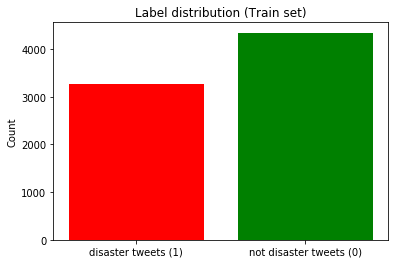

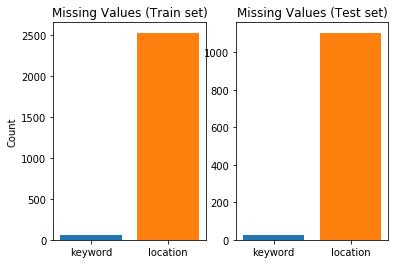

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# Train and Test set size
print(f'Size train data: {train_frame.shape}')
print(f'Size test data: {test_frame.shape}')

# Distribution of the labels
plt1 = plt.bar('disaster tweets (1)',len(train_frame[train_frame.target==1]), color='red')
plt0 = plt.bar('not disaster tweets (0)', len(train_frame[train_frame.target==0]), color='green')
plt.title('Label distribution (Train set)')
plt.ylabel('Count')
plt.show()

# Missing Values (Keyword and Location)
ax1 = plt.subplot(1,2,1)

plt_key = plt.bar('keyword',train_frame.keyword.isnull().sum())
plt_loc = plt.bar('location', train_frame.location.isnull().sum())
plt.title('Missing Values (Train set)')
plt.ylabel('Count')

ax2 = plt.subplot(1,2,2)
plt_key = plt.bar('keyword',test_frame.keyword.isnull().sum())
plt_loc = plt.bar('location', test_frame.location.isnull().sum())
plt.title('Missing Values (Test set)')
plt.show()

# 2. DATA CLEANING

In [18]:
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Sergii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Sergii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Sergii/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# text cleaning and preprocessing:
# Import packages
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string

lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):    
    reviews = []
    for t in tqdm(text):
        
        # Step 1: Transform text to lower case, remove url, punctuations and numbers 
        txt = t.lower()
        txt = re.sub('(http)\S+', '', txt)
        txt = re.sub('[%s]' % re.escape(string.punctuation), ' ', txt)
        txt = re.sub('\d+', '', txt)
        #txt = re.sub('[^\s\w]', '', txt)
        
        # Step 2: Find the tokens of each text, remove stop words and apply lemmatization
        w_txt = word_tokenize(txt)
        words = [ww for ww in w_txt if ww not in stop_words]        
        lem_w = list(map(lambda x: lemma.lemmatize(x, pos='v'), words))
        sent = ' '.join(lem_w)
        reviews.append(sent)
        
    return reviews  

new_data = (lambda x: clean_text(x))(train_frame.text)

100%|██████████| 7613/7613 [00:02<00:00, 3224.39it/s]


In [20]:
# Compare the original text with the new clean text using one of the movie reviews 
print('__Original review:__\n{}\n\n__New review:__\n{}'.format(train_frame.text[0], new_data[0]))

__Original review:__
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

__New review:__
deeds reason earthquake may allah forgive us


# 3. SPLIT DATA

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_data, train_frame.target, random_state=203)

print('Train size:', len(X_train))
print('Test size:', len(X_test))

Train size: 5709
Test size: 1904


# 4. TFIDF AND BUILDING MODELS

In [22]:
# TFIDF anf Logistic Regression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline & Gridsearch setup
# TFIDF pipeline setup
pipe1 = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('lr', LogisticRegression())
])

# Fit
pipe1.fit(X_train, y_train)

# Setting params for TFIDF Vectorizer and LR gridsearch
parameters1 = {'tvec__max_features': [2000,5000,8000,10000,15000,20000], 
              'tvec__max_df': [0.1,0.3,0.5,0.7,1],
              'lr__penalty': ['l1', 'l2'],
              'lr__C': [0.01, 0.1, 1, 10, 100]}

# Setting up GridSearch
tvec_lr = GridSearchCV(pipe1, param_grid=parameters1, cv = 5)
# Fitting GS
tvec_lr.fit(X_train, y_train)

# Best parameters
print('Best parameters:', tvec_lr.best_params_)

#Test score
acc = []
acc.append(tvec_lr.score(X_test, y_test))

Best parameters: {'lr__C': 1, 'lr__penalty': 'l2', 'tvec__max_df': 0.1, 'tvec__max_features': 5000}


In [23]:
# TFIDF and Support Vector Machine
from sklearn.svm import SVC

# Pipeline & Gridsearch setup
# TFIDF pipeline setup
pipe2 = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('svm', SVC())
])

# Fit
pipe2.fit(X_train, y_train)

# Setting params for TFIDF Vectorizer and SVM gridsearch
parameters2 = {'tvec__max_features': [5000, 10000], 
              'tvec__max_df': [0.1],
              'svm__C': [0.01, 0.1, 1, 10, 100],
              'svm__gamma': ['auto', 'scale']}

# Setting up GridSearch
tvec_svm = GridSearchCV(pipe2, param_grid=parameters2, cv = 5)
# Fitting GS
tvec_svm.fit(X_train, y_train)

# Best parameters
print('Best parameters:', tvec_svm.best_params_)

# Test score
acc.append(tvec_svm.score(X_test, y_test))

Best parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'tvec__max_df': 0.1, 'tvec__max_features': 5000}


In [24]:
from sklearn.neighbors import KNeighborsClassifier


# Pipeline & Gridsearch setup
# TFIDF pipeline setup
pipe3 = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('knn', KNeighborsClassifier())
])

# Fit
pipe3.fit(X_train, y_train)

# Setting params for TFIDF Vectorizer and KNN gridsearch
parameters3 = {'tvec__max_features': [2000,5000,8000,10000,15000,20000], 
              'tvec__max_df': [0.1],
              'knn__n_neighbors': [1,3,5]}

# Setting up GridSearch
tvec_knn = GridSearchCV(pipe3, param_grid=parameters3, cv = 5)
# Fitting GS
tvec_knn.fit(X_train, y_train)


# Best parameters
print('Best parameters:', tvec_knn.best_params_)

# Test score
acc.append(tvec_knn.score(X_test, y_test))

Best parameters: {'knn__n_neighbors': 5, 'tvec__max_df': 0.1, 'tvec__max_features': 10000}


In [25]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline & Gridsearch setup
# TFIDF pipeline setup
pipe4 = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('rf', RandomForestClassifier())
])

# Fit
pipe4.fit(X_train, y_train)

# Setting params for TFIDF Vectorizer and RF gridsearch
parameters4 = {'tvec__max_features': [2000,5000,8000,10000,15000,20000], 
              'tvec__max_df': [0.1]}

# Setting up GridSearch
tvec_rf = GridSearchCV(pipe4, param_grid=parameters4, cv = 5)
# Fitting GS
tvec_rf.fit(X_train, y_train)

# Best parameters
print('Best parameters:', tvec_rf.best_params_)

# Test score
acc.append(tvec_rf.score(X_test, y_test))

Best parameters: {'tvec__max_df': 0.1, 'tvec__max_features': 10000}


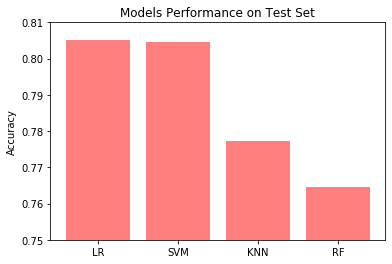

In [32]:
# Plot the test scores from all the ML models
models = ['LR', 'SVM', 'KNN', 'RF']
acc_plt = plt.bar(models, acc, color='red', alpha=0.5)
plt.title('Models Performance on Test Set')
plt.ylabel('Accuracy')
plt.ylim([0.75,0.81])
plt.show()

# 5. ERROR ANALYSIS AND RESULTS

In [28]:
# Confusion Matrix
from sklearn import metrics

print(metrics.classification_report(y_test, tvec_lr.predict(X_test),labels=[0,1]))
print('Confusion Matrix:')
metrics.confusion_matrix(y_test, tvec_lr.predict(X_test))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1081
           1       0.83      0.70      0.76       823

    accuracy                           0.81      1904
   macro avg       0.81      0.79      0.80      1904
weighted avg       0.81      0.81      0.80      1904

Confusion Matrix:


array([[961, 120],
       [251, 572]])

In [29]:
# Most important words for disaster tweets (1)
tvc_title1 = pd.DataFrame(pipe1.steps[1][1].coef_.T, pipe1.steps[0][1].get_feature_names(), columns=['importance_1'])
tvc_title1.sort_values('importance_1', ascending = False).head(10).T

,fire,hiroshima,kill,flood,train,california,wildfire,suicide,earthquake,typhoon
importance_1,3.701469,3.352459,3.064797,2.844307,2.83692,2.599133,2.285611,2.232315,2.200437,2.155244


In [30]:
# Most important words for non-disaster tweets (0)
tvc_title0 = pd.DataFrame(pipe1.steps[1][1].coef_.T, pipe1.steps[0][1].get_feature_names(), columns=['importance_0'])
tvc_title0.sort_values('importance_0', ascending = True).head(10).T

,bag,scream,love,full,ruin,panic,new,put,blaze,crush
importance_0,-2.057649,-1.986881,-1.96225,-1.800255,-1.632379,-1.583744,-1.534846,-1.484257,-1.45748,-1.445547


In [39]:
# Final test table with real labels and predictions
pred_frame = pd.DataFrame(zip(X_test,y_test, tvec_lr.predict(X_test)), columns=['text', 'target', 'pred'])
pred_frame.head()

,text,target,pred
0,themagickidraps upset rally upset burn build b...,1,0
1,name hurricanes black people name terrify hurr...,0,0
2,bowl get think damn blaze damn long,0,0
3,cap drive act represent failure senate republi...,0,0
4,california oil spill might larger project,1,1
